## Planet OS API demo for GEFS 

Note: this notebook requires python3. 

This notebook is an introduction to the PlanetOS API data format using the GFS Global Forecast dataset.

API documentation is available at http://docs.planetos.com. 

If you have questions or comments, join the Planet OS Slack community to chat with our development team.

For general information on usage of IPython/Jupyter and Matplotlib, please refer to their corresponding documentation. https://ipython.org/ and http://matplotlib.org/


### GEFS global probabilistic weather forecast

GEFS is a probabilistic weather forecast system, which is composed of 20 model ensemble members, which differ by small fluctuations in model initial conditions. Probabilistic forecasts try to mimic the natural chaotic nature of the atmosphere and usually have higher forecast skill than deterministic weather forecast, after third day or so. However, their interpretation is not trivial and with this demo we encourage users to have deeper look into this kind of data.

In this tutorial we analyse precipitation and surface pressure data.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser
import datetime
from urllib.request import urlopen, Request
import simplejson as json

In [2]:
def extract_reference_time(API_data_loc):
    """Find reference time that corresponds to most complete forecast. Should be the earliest value."""
    reftimes = set()
    for i in API_data_loc['entries']:
        reftimes.update([i['axes']['reftime']])
    reftimes=list(reftimes)
    if len(reftimes)>1:
        reftime = reftimes[0] if dateutil.parser.parse(reftimes[0])<dateutil.parser.parse(reftimes[1]) else reftimes[1]
    else:
        reftime = reftimes[0]
    return reftime

In [3]:
latitude = 21.205
longitude = -158.35
latitude = 58
longitude = 26
apikey = 'YOUR API KEY HERE'

GEFS is a model with lots of output variables, which may also change depending of which particular output file you are checking. Analyse the metadata first, filter for variables we may be interested in and limit the API request. 

__Warning:__ if requesting too many variables, you may get _gateway timeout error_. If this happens, try to specify only one context or variable.

In [4]:
API_meta_url = "http://api.planetos.com/v1/datasets/noaa-ncep_gefs?apikey={}".format(apikey)
request = Request(API_meta_url)
response = urlopen(request)
API_meta = json.loads(response.read())
print(API_meta_url)

http://api.planetos.com/v1/datasets/noaa-ncep_gefs?apikey=d7d0466b16e24b7084d0c97ea8343762


Filter by parameter name, in this example we wan't to find pressure at surface.

In [5]:
[i['name'] for i in API_meta['Variables'] if 'pressure' in i['name'].lower() and 'surface' in i['name'].lower()]

['Pressure_surface_ens', 'Pressure_potential_vorticity_surface_ens']

API request for precipitation

In [6]:
API_url = "http://api.planetos.com/v1/datasets/noaa-ncep_gefs/point?lon={0}&lat={1}&count=2000&verbose=false&apikey={2}&var=Precipitation_rate_surface_6_Hour_Average_ens".format(longitude,latitude,apikey)
#API_url = "http://api.planetos.com/v1/datasets/noaa-ncep_gefs/point?lon={0}&lat={1}&count=30&verbose=false&apikey={2}".format(longitude,latitude,apikey)
request = Request(API_url)
response = urlopen(request)
API_data_prec = json.loads(response.read())
print(API_url)

http://api.planetos.com/v1/datasets/noaa-ncep_gefs/point?lon=26&lat=58&count=2000&verbose=false&apikey=d7d0466b16e24b7084d0c97ea8343762&var=Precipitation_rate_surface_6_Hour_Average_ens


API request for surface pressure

In [7]:
API_url = "http://api.planetos.com/v1/datasets/noaa-ncep_gefs/point?lon={0}&lat={1}&count=2000&verbose=false&apikey={2}&var=Pressure_surface_ens".format(longitude,latitude,apikey)
request = Request(API_url)
response = urlopen(request)
API_data_pres = json.loads(response.read())
print(API_url)

http://api.planetos.com/v1/datasets/noaa-ncep_gefs/point?lon=26&lat=58&count=2000&verbose=false&apikey=d7d0466b16e24b7084d0c97ea8343762&var=Pressure_surface_ens


Read data from JSON responce and convert to numpy array for easier plotting

In [14]:
## final numpy array, where we collect the data. Note that precipitation data has one less value than pressure
pres_data_array = np.empty([65,20])
prec_data_array = np.empty([64,20])
## temporary dictionaries
pres_data_dict = {}
pres_time_dict = {}
prec_data_dict = {}
prec_time_dict = {}

for i in range(1,21):
    pres_data_dict[i] = []
    pres_time_dict[i] = []
    prec_data_dict[i] = []
    prec_time_dict[i] = []
    
for i in API_data_pres['entries']:
    reftime = extract_reference_time(API_data_pres)
    if reftime == i['axes']['reftime']:
        pres_data_dict[int(i['axes']['iter_ens'])].append(i['data']['Pressure_surface_ens'])
        pres_time_dict[int(i['axes']['iter_ens'])].append(dateutil.parser.parse(i['axes']['time']))
        
for i in API_data_prec['entries']:
    reftime = extract_reference_time(API_data_prec)
    if reftime == i['axes']['reftime']:
        prec_data_dict[int(i['axes']['iter_ens'])].append(i['data']['Precipitation_rate_surface_6_Hour_Average_ens'])
        prec_time_dict[int(i['axes']['iter_ens'])].append(dateutil.parser.parse(i['axes']['time']))
        
## check if time scales are equal?!
for i in range(2,21):
    if np.amax(np.array(pres_time_dict[1])-np.array(pres_time_dict[i])) != datetime.timedelta(0):
        print('timeproblem',np.amax(np.array(pres_time_dict[1])-np.array(pres_time_dict[i])))

## convert lists to numpy array
for i in range(20):
    for j in range(len(pres_time_dict[1])):
        pres_data_array[j,i]=pres_data_dict[i+1][j]

for i in range(20):
    for j in range(len(prec_time_dict[1])):
        prec_data_array[j,i]=6*3600*prec_data_dict[i+1][j]

Compute daily sums of precipitation for later analysis. For longer forecasts and parameters, which do not have diurnal variation, it is often more clear to look at daily values, not 6 hourly.

In [15]:
daily_sum_prec=prec_data_array[0::4,:][:16]+\
prec_data_array[1::4,:]+\
prec_data_array[2::4,:]+\
prec_data_array[3::4,:]

### Precipitation plots
Let's first plot boxplots of ensamble members, showing 6h precipitation and accumulated precipitation.

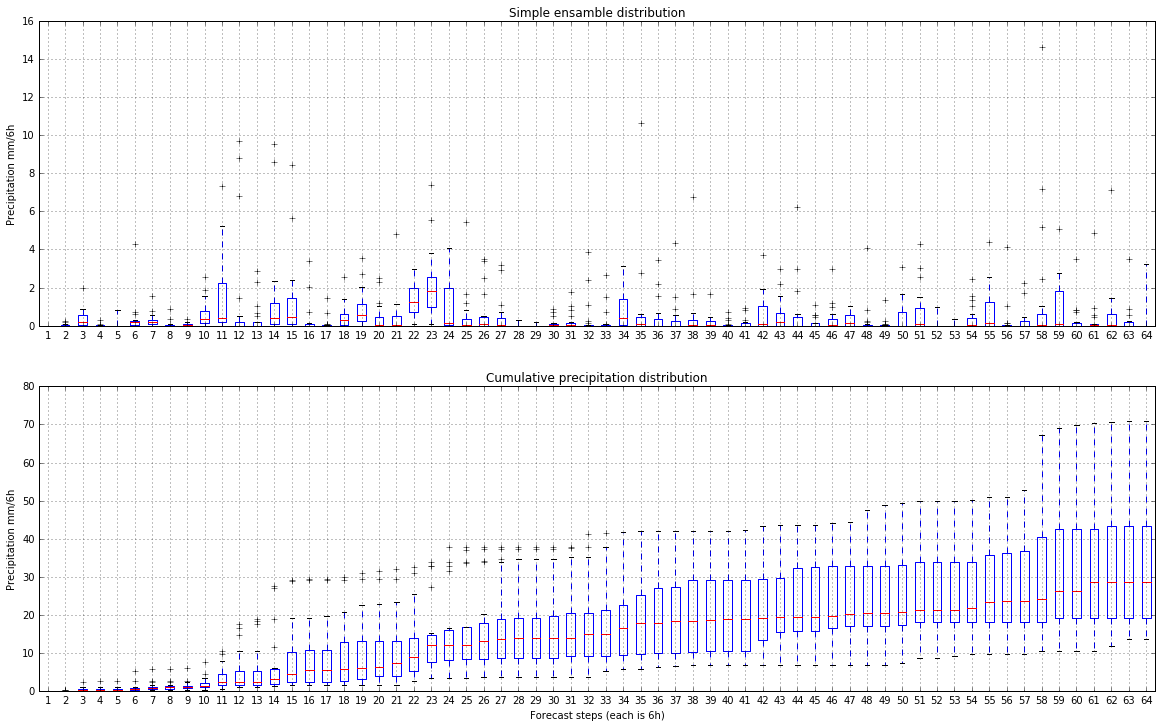

In [27]:
fig, (ax0, ax2) = plt.subplots(nrows=2,figsize=(20,12))
ax0.boxplot(prec_data_array.transpose())
ax0.grid()
ax0.set_title("Simple ensamble distribution")
ax0.set_ylabel('Precipitation mm/6h')

ax2.boxplot(np.cumsum(prec_data_array,axis=0).transpose())
ax2.grid()
ax2.set_title("Cumulative precipitation distribution")
ax2.set_ylabel('Precipitation mm/6h')
ax2.set_xlabel('Forecast steps (each is 6h)')

From simple distribution it is immediately visible that ensamble members may have very different values at particular time. Interpretation of this is highly dependent on physical quantity: for precipitation this may reflect changes in actual weather pattern or just small changes in timing of the precipitation event. To get rid of the latter, we use the accumulated precipitation. From this plot it is more evident (depends on particular forecast of course), that variability is smaller. For longer forecasts it may be more reasonable to check only 24h accumulated precipitation.

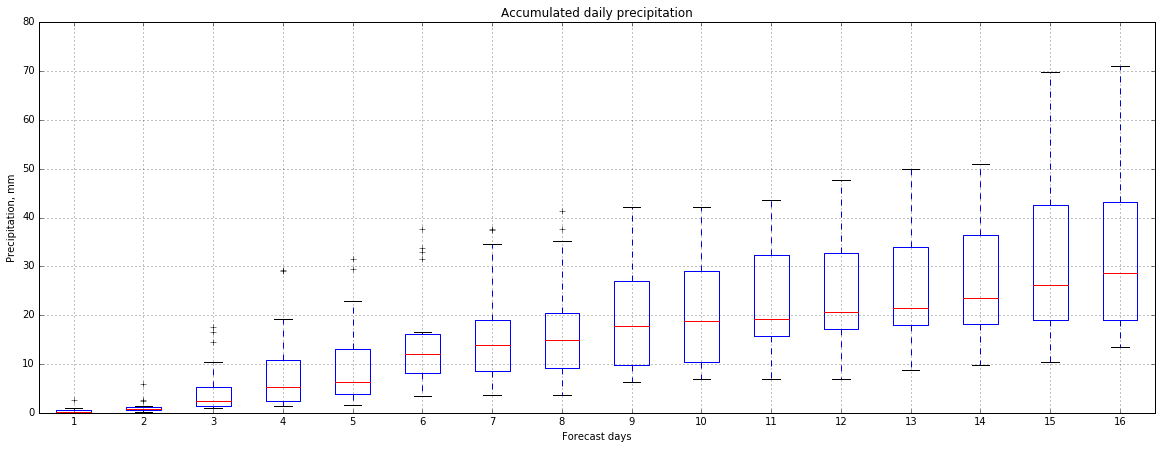

In [23]:
fig=plt.figure(figsize=(20,7))
plt.boxplot(np.cumsum(daily_sum_prec,axis=0).transpose())
plt.grid()
plt.title('Accumulated daily precipitation')
plt.ylabel('Precipitation, mm')
plt.xlabel('Forecast days')

### Surface pressure plots
Surface pressure variation is better descriptor for actual uncertainty than precipitation

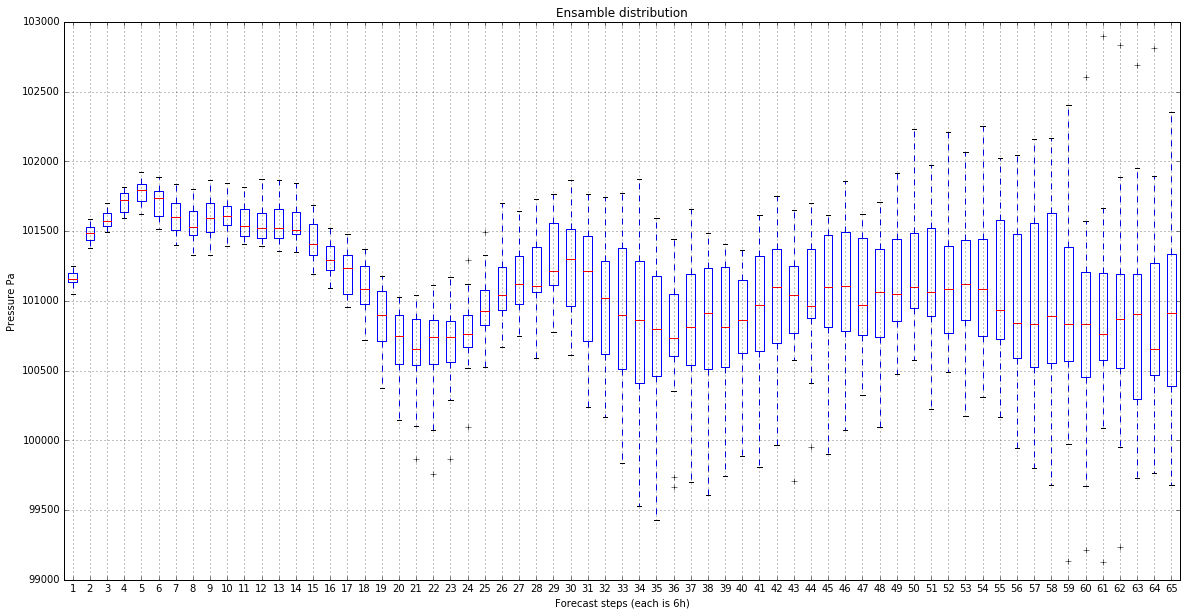

In [22]:
fig=plt.figure(figsize=(20,10))
plt.boxplot(pres_data_array.transpose())
plt.grid()
plt.title('Ensamble distribution')
plt.ylabel('Pressure Pa')
plt.xlabel('Forecast steps (each is 6h)')

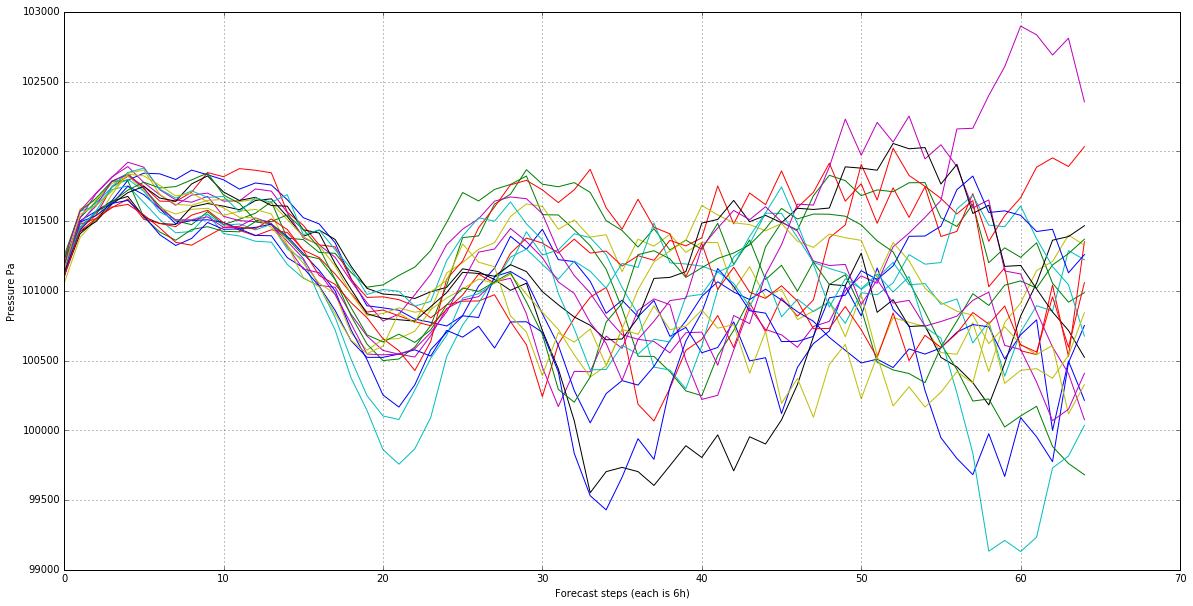

In [21]:
fig=plt.figure(figsize=(20,10))
for i in range(20):
    plt.plot(pres_data_array.transpose()[i,:])
plt.grid()
plt.ylabel('Pressure Pa')
plt.xlabel('Forecast steps (each is 6h)')